# Programming a Convolutional Autoencoder.

---
We are going to test some of its practical features (*interpolation*, *outlier detection* and *denoiser*).
<center><img src="https://i.imgur.com/zdprNMz.png" alt="Drawing" width="600px"/></center>


After designing and training a ***Convolutional Autoencoder*** , we experimented with the following properties of the model:
 

> **1.** *Autoencoder Denoiser :* We generate an image with noise and check that the model is capable of eliminating it. Then, we train the Autoencoder again, but this time adding noise to the *input* and not to the output with the ImageDataGenerator function that I provide us and we train the ***autoencoder*** to see if the model improves its ability to act as a *denoiser*.

> **2.** *Interpolations :* We generate latent vectors for two types of images and visualize. Then we do the mathematical interpolation between the two vectors, for different degrees of mixing, and with the resulting vectors, we reconstruct the images with the *Decoder()*.

> **3.** *Outliers :* We implement a method that acts as a classifier to detect whether or not an image belongs to the MNIST dataset. The method will receive an image as input, and that image will be passed through the Autoencoder, and the ***Reconstruction Error*** will be returned. We look for the threshold by which we can decide whether or not an image belongs to the dataset and we use it to return True or False accordingly.


In [ ]:
import numpy as np
import scipy as sc
import sklearn as sk
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils      import to_categorical

# We load the MNIST dataset.
mnist = np.genfromtxt('./sample_data/mnist_train_small.csv', delimiter=',')

# Separate the labels from the images.
X = mnist[:, 1:]
Y = mnist[:, 0:1]

# We scale the data and One-Hot Encoding the output.
Xn = X / 255
Yn = to_categorical(Y)

# We use Sklearn's data splitter to train/test.
from sklearn.model_selection import train_test_split

# Partition train/test split to monitor overfitting.
X_train, X_test, Y_train, Y_test = train_test_split(Xn, Yn, test_size=0.3)

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.optimizers import *

size = 28 # Image size.

z = 10 # Size of the intermediate vector of the autoencoder.

# First we create the input for the encoder.
inpE = Input(shape=(size, size, 1))  

# Convolutional layers.
encode_1 = Conv2D(filters=32, kernel_size=3, padding="same", strides=2, activation='relu')(inpE)   
encode_2 = Conv2D(filters=64, kernel_size=3, padding="same", strides=2, activation='relu')(encode_1)                      
encode_3 = Conv2D(filters=128, kernel_size=3, strides=2, activation='relu')(encode_2)                             
encode_4 = Flatten()(encode_3) 

# The last layer of the encoder gives us the latent vector.
c = Dense(z, activation="tanh")(encode_4) 

# Create the input for the decoder.
inpD = Input(shape=(z))

# We do a Reshape.
FC = Dense(1152, activation="relu")(inpD)
decode = Reshape(target_shape=(3, 3, 128))(FC)

# We reverse the steps of the encoder.
decode_1 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu')(decode)
decode_2 = Conv2DTranspose(filters=32, kernel_size=3, padding="same", strides=2, activation='relu')(decode_1)
decode_3 = Conv2DTranspose(filters=1, kernel_size=3, padding="same", strides=2, activation='relu')(decode_2)

# Create the encoder and decoder model.
encoder = Model(inputs=inpE, outputs=c)
decoder = Model(inputs=inpD, outputs=decode_3)

# Create the Autoencoder.
autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

# We compile and optimize.
autoencoder.compile(optimizer=Adam(), loss='mse')

In [ ]:
autoencoder.fit(X_train.reshape(-1, size, size, 1), X_train.reshape(-1, size, size, 1), epochs=100, batch_size=128)

Epoch 1/100
110/110 [==============================] - 11s 7ms/step - loss: 0.0654
Epoch 2/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0325
Epoch 3/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0240
Epoch 4/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0208
Epoch 5/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0192
Epoch 6/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0181
Epoch 7/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0173
Epoch 8/100
110/110 [==============================] - 1s 8ms/step - loss: 0.0167
Epoch 9/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0161
Epoch 10/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0157
Epoch 11/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0153
Epoch 12/100
110/110 [==============================] - 1s 6ms/step - loss: 0.0150
Epoch 13/100

In [ ]:
autoencoder.evaluate(X_test.reshape(-1, 28, 28, 1), X_test.reshape(-1, 28, 28, 1))

188/188 [==============================] - 1s 3ms/step - loss: 0.0134


0.013399317860603333

1/1 [==============================] - 0s 146ms/step


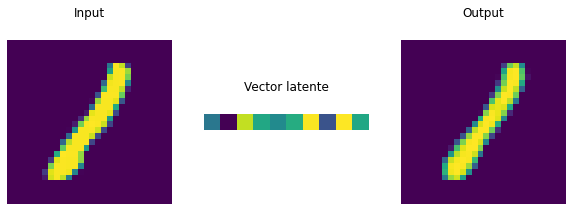

In [ ]:
for enc, dec, mod in [(encoder, decoder, autoencoder)]:

  img = X_test[49].reshape(1, 28, 28, 1)

  fig, axs = plt.subplots(1, 3, figsize=(10, 10))

  fig.axes[0].matshow(img[0,:,:,0])
  fig.axes[0].axis("off")
  fig.axes[0].set_title("Input")

  fig.axes[1].matshow(enc.predict(img))
  fig.axes[1].axis("off")
  fig.axes[1].set_title("Vector latente")

  fig.axes[2].matshow(np.clip(mod.predict(img)[0, :, :, 0],0,1))
  fig.axes[2].axis("off")
  fig.axes[2].set_title("Output")

  plt.show()